In [8]:
"""
Plot number of male neighbors vs original bias
"""

'\nPlot number of male neighbors vs original bias\n'

In [9]:
import argparse
import json

In [10]:
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

In [11]:
from util import preprocessWordVecs, removeWords, load_legacy_w2v
from loader import load_def_sets

In [12]:
def get_most_biased(word_vectors, subspace, n_biased=500):
    """
    Get vectors with most positive and negative bias wrt subspace.
    """

    biases = {}

    for word, vector in word_vectors.items():
        # 1d case
        bias = np.dot(vector, subspace)
        biases[word] = bias

    sorted_biases = sorted(list(biases.items()), key=lambda x: x[1], reverse=True)

    positive_bias = sorted_biases[:n_biased]
    negative_bias = list(reversed(sorted_biases[-n_biased:]))

    return positive_bias, negative_bias

# Plot_multi

In [13]:
def plot_multi(biased_embeddings, debiased_embeddings, vocab_path, targets, bias_specific=None, verbose=None):
    """
    For multi-class: bias direction is from mean to extreme
    """

    # load embeddings
    print("Loading word embeddings...")
    word_vectors, embed_dim = load_legacy_w2v(biased_embeddings)
    debiased_vectors, _ = load_legacy_w2v(debiased_embeddings)

    # prune
    word_vectors = preprocessWordVecs(word_vectors)
    debiased_vectors = preprocessWordVecs(debiased_vectors)

    def_sets = load_def_sets(vocab_path)

    # take first row of def_sets as defining
    classes = def_sets[0]

    vects = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        if word not in word_vectors:
            raise ValueError(word)
        vects[i] = word_vectors[word]
    mean = vects.mean(0)

    directions = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        directions[i] = word_vectors[word] - mean
        directions[i] = directions[i] / np.linalg.norm(directions[i])

    # remove bias-specific words
    if bias_specific is not None:
        biased = json.load(open(bias_specific, 'r'))
    else:
        biased = []
    for value in def_sets.values():
        biased.extend(value)

    word_vectors = removeWords(word_vectors, biased)
    debiased_vectors = removeWords(debiased_vectors, biased)

    targets = json.load(open(targets, 'r'))
    targets = [x[0] for x in targets]
    # compute bias for all targets
    original_bias = {}

    for i, c in enumerate(classes):
        original_bias[c] = {}
        for word in targets:
            if word in word_vectors:
                original_bias[c][word] = np.dot(word_vectors[word], directions[i])

    print(len(original_bias[classes[0]]))
    # get most biased targets
    for c, orig_bias in original_bias.items():
        sorted_prof_bias = sorted(orig_bias.items(), key=lambda x: x[1], reverse=True)
        most_biased_profs = sorted_prof_bias[:10]
        most_antibiased_profs = list(reversed(sorted_prof_bias[-10:]))
        if verbose:
            print("Ten most {}-biased targets".format(c))
            print(most_biased_profs)
            print("Ten most anti-{}-biased targets".format(c))
            print(most_antibiased_profs)
            print()

    # get 500 most biased words in either direction
    positive_words = {}
    negative_words = {}
    print("computing bias of all words in each direction")
    for i, c in enumerate(classes):
        positive_bias, negative_bias = get_most_biased(word_vectors, directions[i])
        print("obtained 500 most positive- and negative-biased words for {}".format(c))

        if verbose:
            print("Ten most biased for {}:".format(c))
            print(positive_bias[:10])
            print("Ten most anti-biased for {}".format(c))
            print(negative_bias[:10])
            print()

        positive_words[c] = [x[0] for x in positive_bias]
        negative_words[c] = [x[0] for x in negative_bias]

    n_closest = {}
    for i, c in enumerate(classes):
        pos_words = positive_words[c]
        neg_words = negative_words[c]
        # get vectors in biased and debiased embeddings
        print("extracting subset of most biased words for {}".format(c))
        subset_size = len(pos_words) + len(neg_words)
        biased_subset = {}
        debiased_subset = {}
        for i, word in enumerate(pos_words + neg_words):
            biased_subset[word] = word_vectors[word]
            debiased_subset[word] = debiased_vectors[word]

        n_closest[c] = {}
        # for each profession, find number of closest numbers that are in the positive class
        for word in original_bias[c].keys():
            # compute distance to all words in subset
            biased_distances = {}
            vec = word_vectors[word]
            for target, t_vec in biased_subset.items():
                biased_distances[target] = np.linalg.norm(t_vec - vec)

            debiased_distances = {}
            vec = debiased_vectors[word]
            for target, t_vec in debiased_subset.items():
                debiased_distances[target] = np.linalg.norm(t_vec - vec)

            # get 100 closest neighbors, count positive class
            closest_biased = sorted(biased_distances.items(), key=lambda x: x[1])[:100]
            closest_debiased = sorted(debiased_distances.items(), key=lambda x: x[1])[:100]

            n_positive = [0, 0]
            for word2, _ in closest_biased:
                if word2 in pos_words:
                    n_positive[0] += 1

            for word2, _ in closest_debiased:
                if word2 in pos_words:
                    n_positive[1] += 1

            n_closest[c][word] = n_positive

    print(len(original_bias[classes[0]]))
    print(len(n_closest[classes[0]]))

    for c in classes:
        try:
            assert set(n_closest[c].keys()) == set(original_bias[c].keys())
        except Exception as e:
            print(set(n_closest[c].keys()).symmetric_difference(set(original_bias[c].keys())))
            raise e

    # plot number of positive neighbors vs. original bias
    figs = []
    for c in classes:
        biases = []
        n_neighbors_biased = []
        n_neighbors_debiased = []
        for word, bias in original_bias[c].items():
            biases.append(bias)
            n_neighbors_biased.append(n_closest[c][word][0])
            n_neighbors_debiased.append(n_closest[c][word][1])

        fig = plt.figure(figsize=(4, 2))
        ax = fig.add_subplot(111)
        # plt.subplot(121)
        plt.scatter(biases, n_neighbors_biased, s=1.5, color='c')
        # plt.title("Original", fontsize='medium')
        ax.text(0.03, 0.88, "Original", fontsize='small', transform=ax.transAxes,
            horizontalalignment='left')
        plt.ylim(0, 100)
        plt.tick_params(labelsize=8)

        # plot most biased targets
        for p, _ in most_biased_profs[:7] + most_antibiased_profs[:7]:
            x = original_bias[c][p]
            y = n_closest[c][p][0]
            # print(p, (x, y))
            plt.annotate(p, xy=(x, y),
                xytext=(np.random.random()*0.1, np.random.random()*0.1),
                textcoords='offset pixels', fontsize='x-small')

        plt.show()
        figs.append(fig)

        fig = plt.figure(figsize=(4, 2))
        ax = fig.add_subplot(111)
        plt.scatter(biases, n_neighbors_debiased, s=1.5, color='c')
        ax.text(0.03, 0.88, f"Debiased", fontsize='small', transform=ax.transAxes,
            horizontalalignment='left')
        plt.ylim(0, 100)
        plt.tick_params(labelsize=8)

        for p, _ in most_biased_profs[:7] + most_antibiased_profs[:7]:
            # print(p)
            x = original_bias[c][p]
            y = n_closest[c][p][1]
            plt.annotate(p, xy=(x, y),
                xytext=(np.random.random()*0.1, np.random.random()*0.1),
                textcoords='offset pixels', fontsize='x-small')

        plt.show()
        figs.append(fig)
        
        print(c)
        print("biased")
        print("Pearson: {}".format(pearsonr(biases, n_neighbors_biased)))
        print("Spearman: {}".format(spearmanr(biases, n_neighbors_biased)))
        print("debiased")
        print("Pearson: {}".format(pearsonr(biases, n_neighbors_debiased)))
        print("Spearman: {}".format(spearmanr(biases, n_neighbors_debiased)))

    # plt.show()

# Plot_binary

In [14]:
def plot_binary(biased_embeddings, debiased_embeddings, vocab_path, targets, bias_specific=None, verbose=None):
    # load embeddings
    print("Loading word embeddings...")
    word_vectors, embed_dim = load_legacy_w2v(biased_embeddings)
    debiased_vectors, _ = load_legacy_w2v(debiased_embeddings)

    # prune
    word_vectors = preprocessWordVecs(word_vectors)
    debiased_vectors = preprocessWordVecs(debiased_vectors)

    # assume gender direction is just he - she
    gender_direction = word_vectors['he'] - word_vectors['she']
    gender_direction = gender_direction / np.linalg.norm(gender_direction)
    debiased_direction = debiased_vectors['he'] - debiased_vectors['she']

    # remove gender-specific words
    def_sets = load_def_sets(vocab_path)
    if bias_specific is not None:
        biased = json.load(open(bias_specific, 'r'))
    else:
        biased = []

    for value in def_sets.values():
        biased.extend(value)
    word_vectors = removeWords(word_vectors, biased)
    debiased_vectors = removeWords(debiased_vectors, biased)

    targets = json.load(open(targets, 'r'))
    targets = [x[0] for x in targets]
    # compute bias for all targets
    original_bias = {}
    for word in targets:
        if word in word_vectors:
            original_bias[word] = np.dot(word_vectors[word], gender_direction)

    print(len(original_bias))
    # get most biased targets
    sorted_prof_bias = sorted(original_bias.items(), key=lambda x: x[1], reverse=True)

    if verbose:
        print("Ten most male-biased targets")
        print(sorted_prof_bias[:10])
        print("Ten most female-biased targets")
        print(list(reversed(sorted_prof_bias[-10:])))
        print()

    # get 500 most biased words in either direction
    print("computing bias of all words")
    positive_bias, negative_bias = get_most_biased(word_vectors, gender_direction)
    
    if verbose:
        print("Ten most male-biased")
        print(positive_bias[:10])
        print("Ten most anti-male-biased")
        print(negative_bias[:10])
        print()

    print("obtained 500 most positive- and negative-biased words")
    positive_words = [x[0] for x in positive_bias]
    negative_words = [x[0] for x in negative_bias]

    # get vectors in biased and debiased embeddings
    print("extracting subset of most biased words")
    subset_size = len(positive_words) + len(negative_words)
    # biased_subset = np.zeros((subset_size, embed_dim))
    # debiased_subset = np.zeros_like(biased_subset)
    biased_subset = {}
    debiased_subset = {}
    for i, word in enumerate(positive_words + negative_words):
        biased_subset[word] = word_vectors[word]
        debiased_subset[word] = debiased_vectors[word]

    # for each profession, find number of closest numbers that are in the positive class
    n_closest = {}
    for word in original_bias.keys():
        # compute distance to all words in subset
        biased_distances = {}
        vec = word_vectors[word]
        for target, t_vec in biased_subset.items():
            biased_distances[target] = np.linalg.norm(t_vec - vec)

        debiased_distances = {}
        vec = debiased_vectors[word]
        for target, t_vec in debiased_subset.items():
            debiased_distances[target] = np.linalg.norm(t_vec - vec)

        # get 100 closest neighbors, count positive class
        closest_biased = sorted(biased_distances.items(), key=lambda x: x[1])[:100]
        closest_debiased = sorted(debiased_distances.items(), key=lambda x: x[1])[:100]

        n_positive = [0, 0]
        for word2, _ in closest_biased:
            if word2 in positive_words:
                n_positive[0] += 1

        for word2, _ in closest_debiased:
            if word2 in positive_words:
                n_positive[1] += 1

        n_closest[word] = n_positive

    print(len(original_bias))
    print(len(n_closest))

    try:
        assert set(n_closest.keys()) == set(original_bias.keys())
    except Exception as e:
        print(set(n_closest.keys()).symmetric_difference(set(original_bias.keys())))
        raise e

    # plot number of positive neighbors vs. original bias
    biases = []
    n_neighbors_biased = []
    n_neighbors_debiased = []
    for word, bias in original_bias.items():
        biases.append(bias)
        n_neighbors_biased.append(n_closest[word][0])
        n_neighbors_debiased.append(n_closest[word][1])

    plt.figure(figsize=(10, 3.5))
    plt.subplot(121)
    plt.scatter(biases, n_neighbors_biased, s=1.5)
    plt.title("Original")

    plt.subplot(122)
    plt.scatter(biases, n_neighbors_debiased, s=2)
    plt.title("Debiased")

    print("Pearson: {}".format(pearsonr(biases, n_neighbors_biased)))
    print("Spearman: {}".format(spearmanr(biases, n_neighbors_biased)))
    print("Pearson (debiased): {}".format(pearsonr(biases, n_neighbors_debiased)))
    print("Spearman (debiased): {}".format(spearmanr(biases, n_neighbors_debiased)))
    
    plt.show()

# Rest

Loading word embeddings...
253
Ten most male-biased targets
[('midfielder', 0.45367944395340387), ('goalkeeper', 0.43236988459147735), ('commander', 0.40435483348326995), ('crusader', 0.4012622246447719), ('marshal', 0.3638527696691203), ('commissioner', 0.3532391950118219), ('marksman', 0.3464902749072246), ('baron', 0.34038179842287786), ('chancellor', 0.3243341978092679), ('negotiator', 0.3205027367811598)]
Ten most female-biased targets
[('stylist', -0.4738521080541447), ('nurse', -0.38619607398686895), ('confesses', -0.3745347852801356), ('maid', -0.3676198762905253), ('therapist', -0.35543224655135786), ('hairdresser', -0.34625982657000914), ('doctor', -0.3409284201024776), ('pediatrician', -0.33976050008529435), ('counselor', -0.330995848088507), ('dermatologist', -0.32514493985155524)]

computing bias of all words
Ten most male-biased
[('cfc', 0.6862915054656281), ('starkiller', 0.6097819604475139), ('eugen', 0.6050943077379223), ('blufor', 0.6018509993206507), ('jsdf', 0.60169

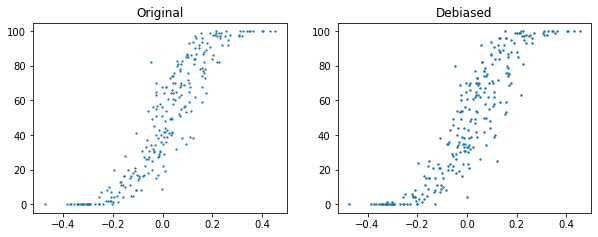

In [22]:
plot_binary('../data/Manzini/reddit.US.txt.tok.clean.cleanedforw2v_0.w2v', 
            '../data/Manzini/data_vocab_race_attributes_optm_json_role_hardDebiasedEmbeddingsOut.w2v',
            '../data/vocab/race_attributes_optm.json', 
            '../data/lists/professions.json',
           verbose=True)